In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
import math

In [21]:
# Import for cointegration
from arch.unitroot.cointegration import engle_granger

In [14]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.rename(columns=lambda c: str(c), inplace=True)
df["time"] = pd.to_datetime([i for i in range(750)], unit='D', origin=pd.Timestamp('2020-01-01'))
df.set_index("time", inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,13.46,71.65,48.46,50.52,52.10,13.00,18.98,47.71,69.49,49.96,...,32.64,55.76,14.46,58.94,36.71,52.62,49.33,36.22,49.00,56.09
2020-01-02,13.48,72.10,48.52,50.50,52.06,12.95,18.95,47.84,69.73,49.93,...,32.52,55.97,14.44,59.81,36.64,52.58,49.20,36.27,48.84,56.08
2020-01-03,13.47,72.35,48.48,50.62,51.80,12.79,18.98,47.98,69.60,49.33,...,32.48,56.34,14.50,59.04,36.89,52.49,49.48,36.39,48.56,55.90
2020-01-04,13.53,72.51,48.42,50.75,51.66,12.66,18.96,48.74,69.54,49.67,...,32.59,56.32,14.40,58.73,36.94,52.40,49.42,36.41,49.00,56.14
2020-01-05,13.64,71.99,48.40,50.65,51.97,12.62,18.89,48.88,69.68,49.46,...,32.64,56.32,14.36,59.01,37.03,52.44,49.79,36.42,48.14,55.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-15,10.32,63.28,45.54,43.35,52.64,7.91,17.30,55.30,67.83,58.73,...,28.81,79.78,10.85,61.76,30.12,48.51,82.09,34.95,35.80,52.57
2022-01-16,10.32,63.34,45.56,43.28,52.73,7.87,17.26,54.92,67.95,58.62,...,28.78,80.46,10.77,61.49,29.85,48.40,81.43,34.99,35.58,53.10
2022-01-17,10.32,63.23,45.55,43.25,52.66,7.83,17.32,54.67,67.94,59.15,...,28.73,81.15,10.75,60.36,29.77,48.41,81.90,35.00,35.45,53.21


In [51]:
preTrain = df[:500][:]
preTest = df[500:750][:]

In [52]:
train = np.log(preTrain)
test = np.log(preTest)

time
2020-01-01    2.599722
2020-01-02    2.601207
2020-01-03    2.600465
2020-01-04    2.604909
2020-01-05    2.613007
                ...   
2021-05-10    2.616666
2021-05-11    2.608598
2021-05-12    2.616666
2021-05-13    2.606387
2021-05-14    2.595255
Name: 0, Length: 500, dtype: float64
2.599722324216582


In [41]:
# Check if stationary
# Non-stationary
def test_stationary(series, printing=False):
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    if printing:
        print("Results of Dickey-Fuller Test:")
        print(dfoutput)

    
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    if printing:
        print("Results of KPSS Test:")
        print(kpss_output)
    
    isStationary = dfoutput["p-value"] < 0.05 and kpss_output["p-value"] > 0.05
    if printing:
        print("STATIONARY: ", isStationary)    

    return (dfoutput["p-value"], kpss_output["p-value"], isStationary)

In [20]:
# Find cointegrated pair with statsmodel
threshold = 0.05

coint_pairs = []
train_coint_matrix = [[-1] * 50 for i in range(50)]
test_coint_matrix = [[-1] * 50 for i in range(50)]
for i in range(50):
    for j in range(i+1, 50):
        train_coint_pVal = stattools.coint(train[str(i)], train[str(j)])[1]
        test_coint_pVal = stattools.coint(test[str(i)], test[str(j)])[1]
        train_coint_matrix[i][j] = train_coint_pVal
        test_coint_matrix[i][j] = test_coint_pVal

        if (train_coint_pVal < threshold and test_coint_pVal < threshold):
            coint_pairs.append((i, j))

print(coint_pairs)


[(1, 10), (14, 27), (14, 36), (14, 38), (14, 44), (28, 49)]


In [54]:
# Get the cointegration vectors with engle_granger
threshold = 0.05
coint_vecs = {}
pairs = []
for i in range(50):
    for j in range(i+1, 50):
        pair = (i, j)
        result = engle_granger(train[str(pair[0])], train[str(pair[1])], trend='ct', method='bic')
        testTest = engle_granger(test[str(pair[0])], test[str(pair[1])], trend='ct', method='bic')
        if result.pvalue < threshold and testTest.pvalue < threshold:
            coint_vecs[pair] = result.cointegrating_vector[:2]
            print(pair, result.pvalue, testTest.pvalue)
            pairs.append(pair)

(13, 18) 0.0027344749555273957 0.03003028740464072
(14, 25) 0.04874315150370443 0.029124302005262014
(14, 27) 0.022589065911523397 0.02865631780454482
(14, 28) 0.008229566880659416 0.027122234560988133
(14, 32) 0.014716963378619167 0.03326307681981615
(14, 38) 0.026222173891773472 0.027664142033792503
(14, 39) 0.003636441203140672 0.031080011924795096
(14, 41) 0.037990020470584085 0.016074054970713438
(14, 44) 0.03960812734480908 0.027319934544490644
(17, 22) 0.032022444366286144 0.018494971121557287
(36, 41) 0.04588698333959969 0.041913243253812134


(13, 18)
13    1.000000
18   -1.393478
dtype: float64
(14, 25)
14    1.000000
25   -0.322756
dtype: float64
(14, 27)
14    1.000000
27   -4.676016
dtype: float64
(14, 28)
14    1.000000
28   -2.144227
dtype: float64
(14, 32)
14    1.000000
32   -0.517485
dtype: float64
(14, 38)
14    1.000000
38   -2.315903
dtype: float64


C:\Users\DELL\AppData\Local\Temp\ipykernel_14292\2814350545.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")
C:\Users\DELL\AppData\Local\Temp\ipykernel_14292\2814350545.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")
C:\Users\DELL\AppData\Local\Temp\ipykernel_14292\2814350545.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")
C:\Users\DELL\AppData\Local\Temp\ipykernel_14292\2814350545.py:21: InterpolationWarning: The test st

(14, 39)
14    1.000000
39   -4.697189
dtype: float64
(14, 41)
14    1.000000
41   -0.330547
dtype: float64
(14, 44)
14    1.000000
44   -0.394664
dtype: float64
(17, 22)
17    1.000000
22   -0.136714
dtype: float64
(36, 41)
36    1.000000
41   -0.298467
dtype: float64


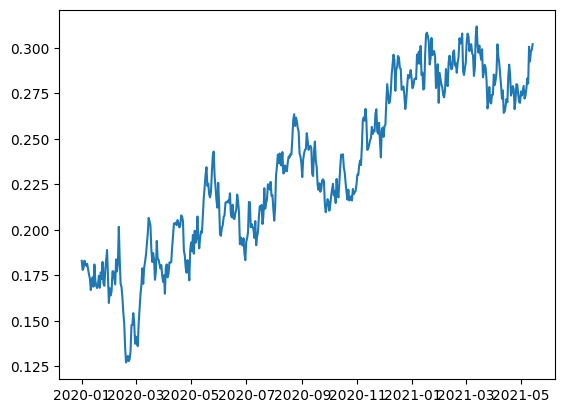

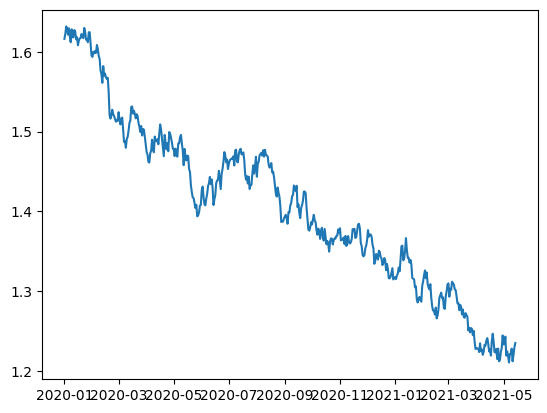

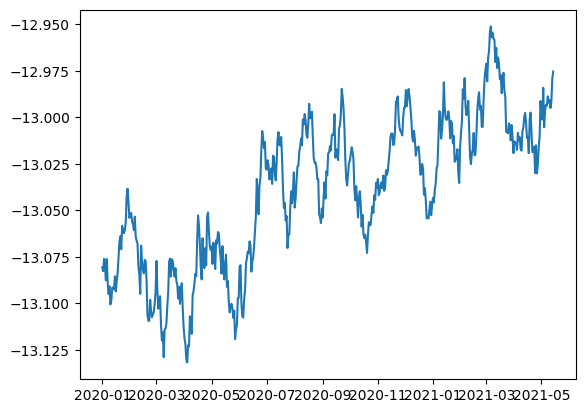

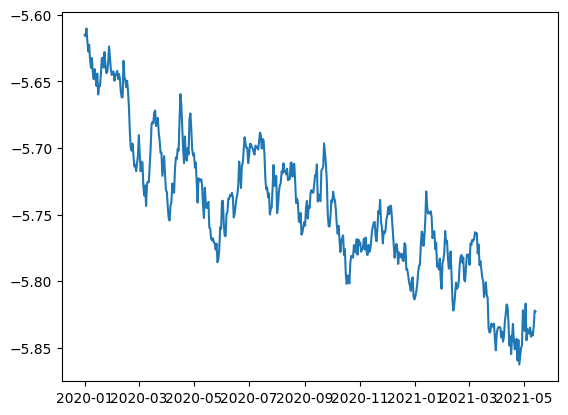

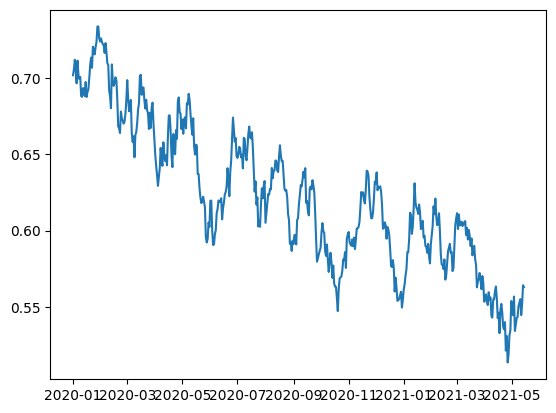

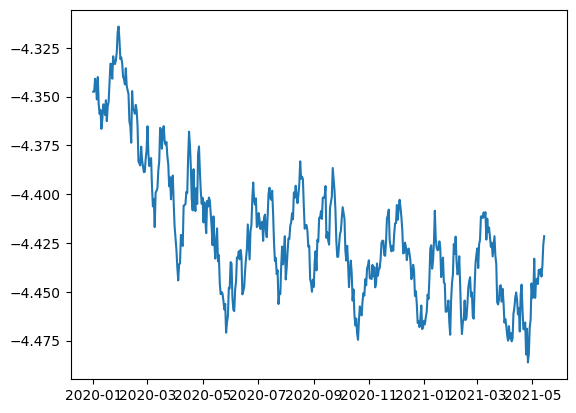

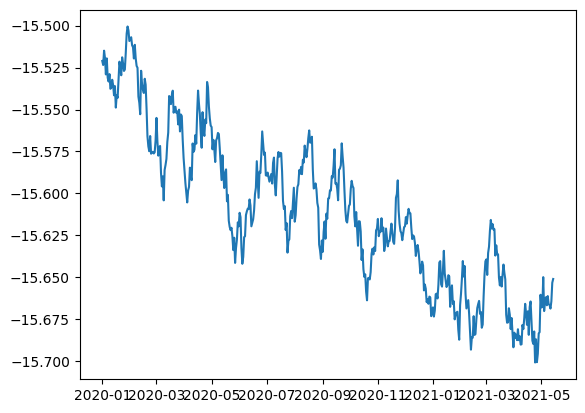

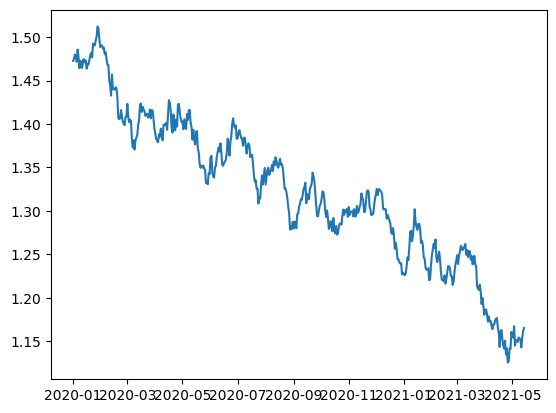

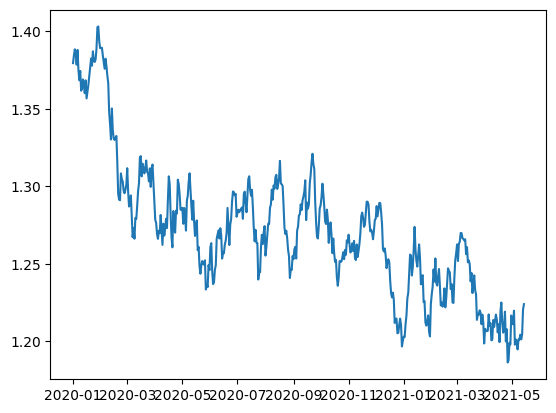

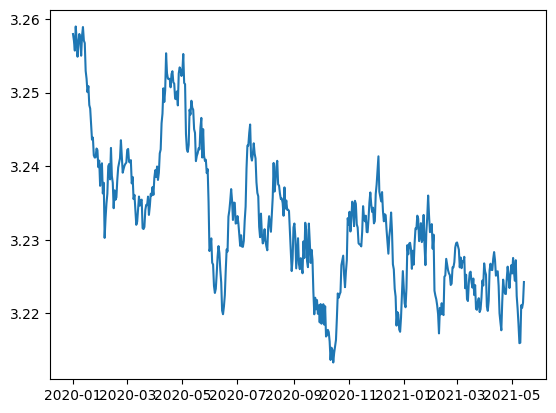

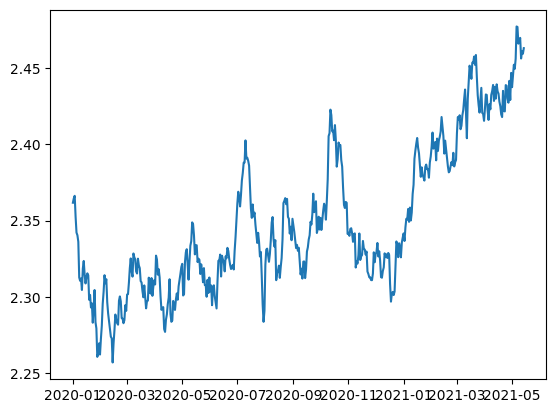

In [56]:
# Try the pair (13, 18), (14, 39), (17, 22), (36, 41) to start
# pairs = [(13, 18), (14, 39), (17, 22), (36, 41)]
for pair in pairs:
    print(pair)
    print(coint_vecs[pair])
    beta = coint_vecs[pair].values
    residualTrain = beta[0] * train[str(pair[0])] + beta[1] * train[str(pair[1])]
    if test_stationary(residualTrain, printing=False)[2] == False:
        plt.figure()
        plt.plot(residualTrain)